In [16]:
from regions import Regions
import numpy as np
from regions import PixCoord
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS

import Paths.Paths as paths
Path = paths.filepaths()

w51e_reg_file = '/orange/adamginsburg/w51/TaehwaYoo/regions/regions_/adam_sourceid_on_w51e2_20250701.reg'
w51n_reg_file = '/orange/adamginsburg/w51/TaehwaYoo/regions/regions_/adam_sourceid_on_w51n_20250701.reg'
w51e_reg = Regions.read(w51e_reg_file)
w51n_reg = Regions.read(w51n_reg_file)

def indexing_regions(regfile):
    reg_list = []
    regs = Regions.read(regfile, format='ds9')
    with open(regfile, 'r') as f:
        for idx, line in enumerate(f):
            if 'width' in line:
                reg_list.append(line)

    b3b6_regs = []
    b3only_regs = []
    for i, reg in enumerate(reg_list):
        if 'color=#cyan' in reg:
            b3b6_regs.append(i)
        elif 'color=#red' in reg:
            b3only_regs.append(i)
    return b3b6_regs, b3only_regs
w51e_b3b6_reg_idx, w51e_b3only_reg_idx = indexing_regions(w51e_reg_file)
w51n_b3b6_reg_idx, w51n_b3only_reg_idx = indexing_regions(w51n_reg_file)




In [17]:
w51e_b3_reg_idx = w51e_b3b6_reg_idx+w51e_b3only_reg_idx
w51e_b6_reg_idx = w51e_b3b6_reg_idx
w51n_b3_reg_idx = w51n_b3b6_reg_idx+w51n_b3only_reg_idx
w51n_b6_reg_idx = w51n_b3b6_reg_idx

w51e_b3_reg = [reg for i, reg in enumerate(w51e_reg) if i in w51e_b3_reg_idx]
w51e_b6_reg = [reg for i, reg in enumerate(w51e_reg) if i in w51e_b6_reg_idx]
w51n_b3_reg = [reg for i, reg in enumerate(w51n_reg) if i in w51n_b3_reg_idx]
w51n_b6_reg = [reg for i, reg in enumerate(w51n_reg) if i in w51n_b6_reg_idx]



In [ ]:
def compare_with_initial_dendro(init_dendro, regs, wcs):
    pixcoords = PixCoord(init_dendro['peak_x'], init_dendro['peak_y'])

    selected_regs = []
    unselected_regs = []
    selected_peaks_x = []
    selected_peaks_y = []
    for reg in regs:
        reg_pix = reg.to_pixel(wcs)
        if any(reg_pix.contains(pixcoords)):
           # print('matched with dendro')
            selected_regs.append(reg)

            iscontain = reg_pix.contains(pixcoords)
            selected_peak_x = init_dendro['peak_x'][iscontain]
            selected_peak_y = init_dendro['peak_y'][iscontain]
            selected_peak_value = init_dendro['peak_value'][iscontain]
            if len(selected_peak_x) > 1:
                maxind = np.argmax(selected_peak_value)
                selected_peaks_x.append(selected_peak_x[maxind].item())
                selected_peaks_y.append(selected_peak_y[maxind].item())
            elif len(selected_peak_x) == 1:
                selected_peaks_x.append(selected_peak_x.item())
                selected_peaks_y.append(selected_peak_y.item())


        else:
#            print('not matched with dendro')
            unselected_regs.append(reg)
    print(f'Number of selected regions: {len(selected_regs)}')
    print(f'Number of unselected regions: {len(unselected_regs)}')
    print(f'Number of total regions: {len(regs)}')
    print(f'Number of selected initial dendrogram peaks: {len(selected_peaks_x)}')
    print(f'Number of initial dendrogram peaks: {len(init_dendro)}')
    print(selected_peaks_x)
    return selected_regs, unselected_regs, selected_peaks_x, selected_peaks_y


In [ ]:
import matplotlib.pyplot as plt

def plot_selected_regions(ax, wcs , selected_regs, unselected_regs, selected_peaks_x, selected_peaks_y):
    from regions import Regions
    from astropy.visualization.wcsaxes import WCSAxes
    
    for reg in selected_regs:
        reg_pix = reg.to_pixel(wcs)
        reg_pix.plot(ax=ax, facecolor='none', edgecolor='cyan', lw=1)
    
    for reg in unselected_regs:
        reg_pix = reg.to_pixel(wcs)
        reg_pix.plot(ax=ax, facecolor='none', edgecolor='red', lw=1)
    
    ax.scatter(selected_peaks_x, selected_peaks_y, color='blue', marker='x', label='Peaks')
    ax.scatter()

    
fitslist = [Path.w51n_b3_tt0, Path.w51n_b6_cont, Path.w51e_b3_tt0, Path.w51e_b6_cont]
init_dendrolist = ['W51-IRS2_B3_initial_dendro.fits', 'W51-IRS2_B6_initial_dendro.fits', 'W51-E_B3_initial_dendro.fits', 'W51-E_B6_initial_dendro.fits']

def plot_main(region, band):
    if region=='W51-E':
        if band=='B3':
            fitsfile = Path.w51e_b3_tt0
            init_dendrofile = 'W51-E_B3_initial_dendro.fits'
            regs = w51e_b3_reg 
        elif band=='B6':
            fitsfile = Path.w51e_b6_cont
            init_dendrofile = 'W51-E_B6_initial_dendro.fits'
            regs = w51e_b6_reg
    elif region=='W51-IRS2':
        if band=='B3':
            fitsfile = Path.w51n_b3_tt0
            init_dendrofile = 'W51-IRS2_B3_initial_dendro.fits'
            regs = w51n_b3_reg
        elif band=='B6':
            fitsfile = Path.w51n_b6_cont
            init_dendrofile = 'W51-IRS2_B6_initial_dendro.fits'
            regs = w51n_b6_reg

    fits_data = fits.open(fitsfile)
    hdr = fits.getheader(fitsfile)
    init_dendro = Table.read(init_dendrofile)
    wcs = WCS(hdr, naxis=2)
    
    selected_regs, unselected_regs, selected_peaks_x, selected_peaks_y = compare_with_initial_dendro(init_dendro, regs, wcs)
    print(selected_peaks_x, selected_peaks_y)
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(111, projection=WCS(hdr, naxis=2))
    ax.imshow(fits_data[0].data[0][0], origin='lower', cmap='gray', vmin=0, vmax=1.5e-3)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    plot_selected_regions(ax, wcs, selected_regs, unselected_regs, selected_peaks_x, selected_peaks_y)
    plt.savefig(f'{region}_{band}_adam_selected_regions.png', bbox_inches='tight', dpi=300)
    
    

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of selected regions: 95
Number of unselected regions: 41
Number of total regions: 136
[7004, 6901, 7101, 7079, 7136, 7149, 7403, 7430, 7193, 7270, 7335, 7339, 7318, 7271, 7213, 7200, 7202, 7517, 7195, 6788, 7482, 7823, 7369, 7961, 8009, 8132, 6996, 7104, 6873, 7074, 7018, 7028, 8332, 8088, 7869, 7958, 8261, 8746, 8744, 8683, 7566, 7543, 7496, 7501, 7423, 7436, 7603, 7488, 7514, 7548, 7440, 7423, 7415, 7369, 7356, 7325, 7357, 7286, 7274, 7258, 7311, 7253, 7253, 7264, 3790, 8710, 8786, 8792, 8895, 8532, 9192, 9383, 10031, 9968, 10762, 10610, 11492, 11570, 11551, 11765, 11550, 10310, 10934, 9437, 11350, 12290, 10393, 9934, 9845, 7571, 6969, 7712, 7312, 7309, 7310]
[7004, 6901, 7101, 7079, 7136, 7149, 7403, 7430, 7193, 7270, 7335, 7339, 7318, 7271, 7213, 7200, 7202, 7517, 7195, 6788, 7482, 7823, 7369, 7961, 8009, 8132, 6996, 7104, 6873, 7074, 7018, 7028, 8332, 8088, 7869, 7958, 8261, 8746, 8744, 8683, 7566, 7543, 7496, 7501, 7423, 7436, 7603, 7488, 7514, 7548, 7440, 7423, 7415, 7369

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of selected regions: 80
Number of unselected regions: 24
Number of total regions: 104
[6817, 6649, 6987, 6949, 7046, 7071, 7279, 7098, 7517, 7563, 7148, 7209, 7283, 7398, 7403, 7369, 7285, 7184, 7162, 7167, 7068, 7151, 6440, 7912, 8252, 7412, 7457, 8493, 8576, 8793, 6927, 7082, 6806, 6993, 6588, 6950, 6843, 6860, 5498, 9141, 8716, 10191, 8333, 8487, 7678, 9018, 9867, 9863, 9756, 9712, 7802, 7761, 7680, 7679, 7688, 7551, 7576, 7580, 7865, 7665, 7711, 7689, 7770, 7582, 7546, 7555, 7539, 7455, 7432, 7380, 7437, 7310, 7288, 7288, 7262, 7355, 7253, 7251, 7272, 7357]
[6817, 6649, 6987, 6949, 7046, 7071, 7279, 7098, 7517, 7563, 7148, 7209, 7283, 7398, 7403, 7369, 7285, 7184, 7162, 7167, 7068, 7151, 6440, 7912, 8252, 7412, 7457, 8493, 8576, 8793, 6927, 7082, 6806, 6993, 6588, 6950, 6843, 6860, 5498, 9141, 8716, 10191, 8333, 8487, 7678, 9018, 9867, 9863, 9756, 9712, 7802, 7761, 7680, 7679, 7688, 7551, 7576, 7580, 7865, 7665, 7711, 7689, 7770, 7582, 7546, 7555, 7539, 7455, 7432, 7380, 743

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of selected regions: 59
Number of unselected regions: 59
Number of total regions: 118
[7248, 5318, 7008, 7047, 7047, 7028, 7491, 7552, 7628, 7604, 7648, 7782, 7826, 7764, 7343, 7272, 7256, 7083, 7115, 7146, 8101, 8253, 9821, 7310, 3141, 8018, 10987, 11283, 13741, 9858, 9972, 9983, 9571, 9709, 9687, 9727, 10218, 10202, 10391, 10576, 10523, 9451, 10972, 1858, 1919, 1277, 2497, 2657, 3380, 3458, 3652, 3439, 3404, 3450, 3442, 3440, 2198, 3237, 785]
[7248, 5318, 7008, 7047, 7047, 7028, 7491, 7552, 7628, 7604, 7648, 7782, 7826, 7764, 7343, 7272, 7256, 7083, 7115, 7146, 8101, 8253, 9821, 7310, 3141, 8018, 10987, 11283, 13741, 9858, 9972, 9983, 9571, 9709, 9687, 9727, 10218, 10202, 10391, 10576, 10523, 9451, 10972, 1858, 1919, 1277, 2497, 2657, 3380, 3458, 3652, 3439, 3404, 3450, 3442, 3440, 2198, 3237, 785] [7374, 7617, 7361, 7358, 7342, 7167, 7286, 7307, 7226, 7294, 7273, 7331, 7273, 7278, 7299, 7367, 7409, 7351, 7311, 7319, 7129, 7015, 7570, 7783, 8034, 10882, 7517, 7350, 6922, 4771,

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of selected regions: 38
Number of unselected regions: 15
Number of total regions: 53
[7283, 7220, 7420, 7130, 7324, 7431, 7428, 8004, 7998, 4049, 7005, 7076, 7075, 7041, 7851, 7960, 8095, 8050, 8111, 8129, 8362, 8439, 8330, 7592, 7469, 7450, 7483, 7438, 7138, 7192, 7248, 6099, 8918, 9185, 7869, 7923, 11931, 7532]
[7283, 7220, 7420, 7130, 7324, 7431, 7428, 8004, 7998, 4049, 7005, 7076, 7075, 7041, 7851, 7960, 8095, 8050, 8111, 8129, 8362, 8439, 8330, 7592, 7469, 7450, 7483, 7438, 7138, 7192, 7248, 6099, 8918, 9185, 7869, 7923, 11931, 7532] [7246, 7279, 7403, 7101, 7135, 7317, 7338, 7281, 7020, 7771, 7321, 7317, 7289, 6982, 7189, 7230, 7087, 7206, 7179, 7168, 7271, 7167, 7177, 7213, 7331, 7323, 7305, 7404, 7305, 7233, 7247, 7004, 6915, 6717, 7151, 7179, 7692, 8021]


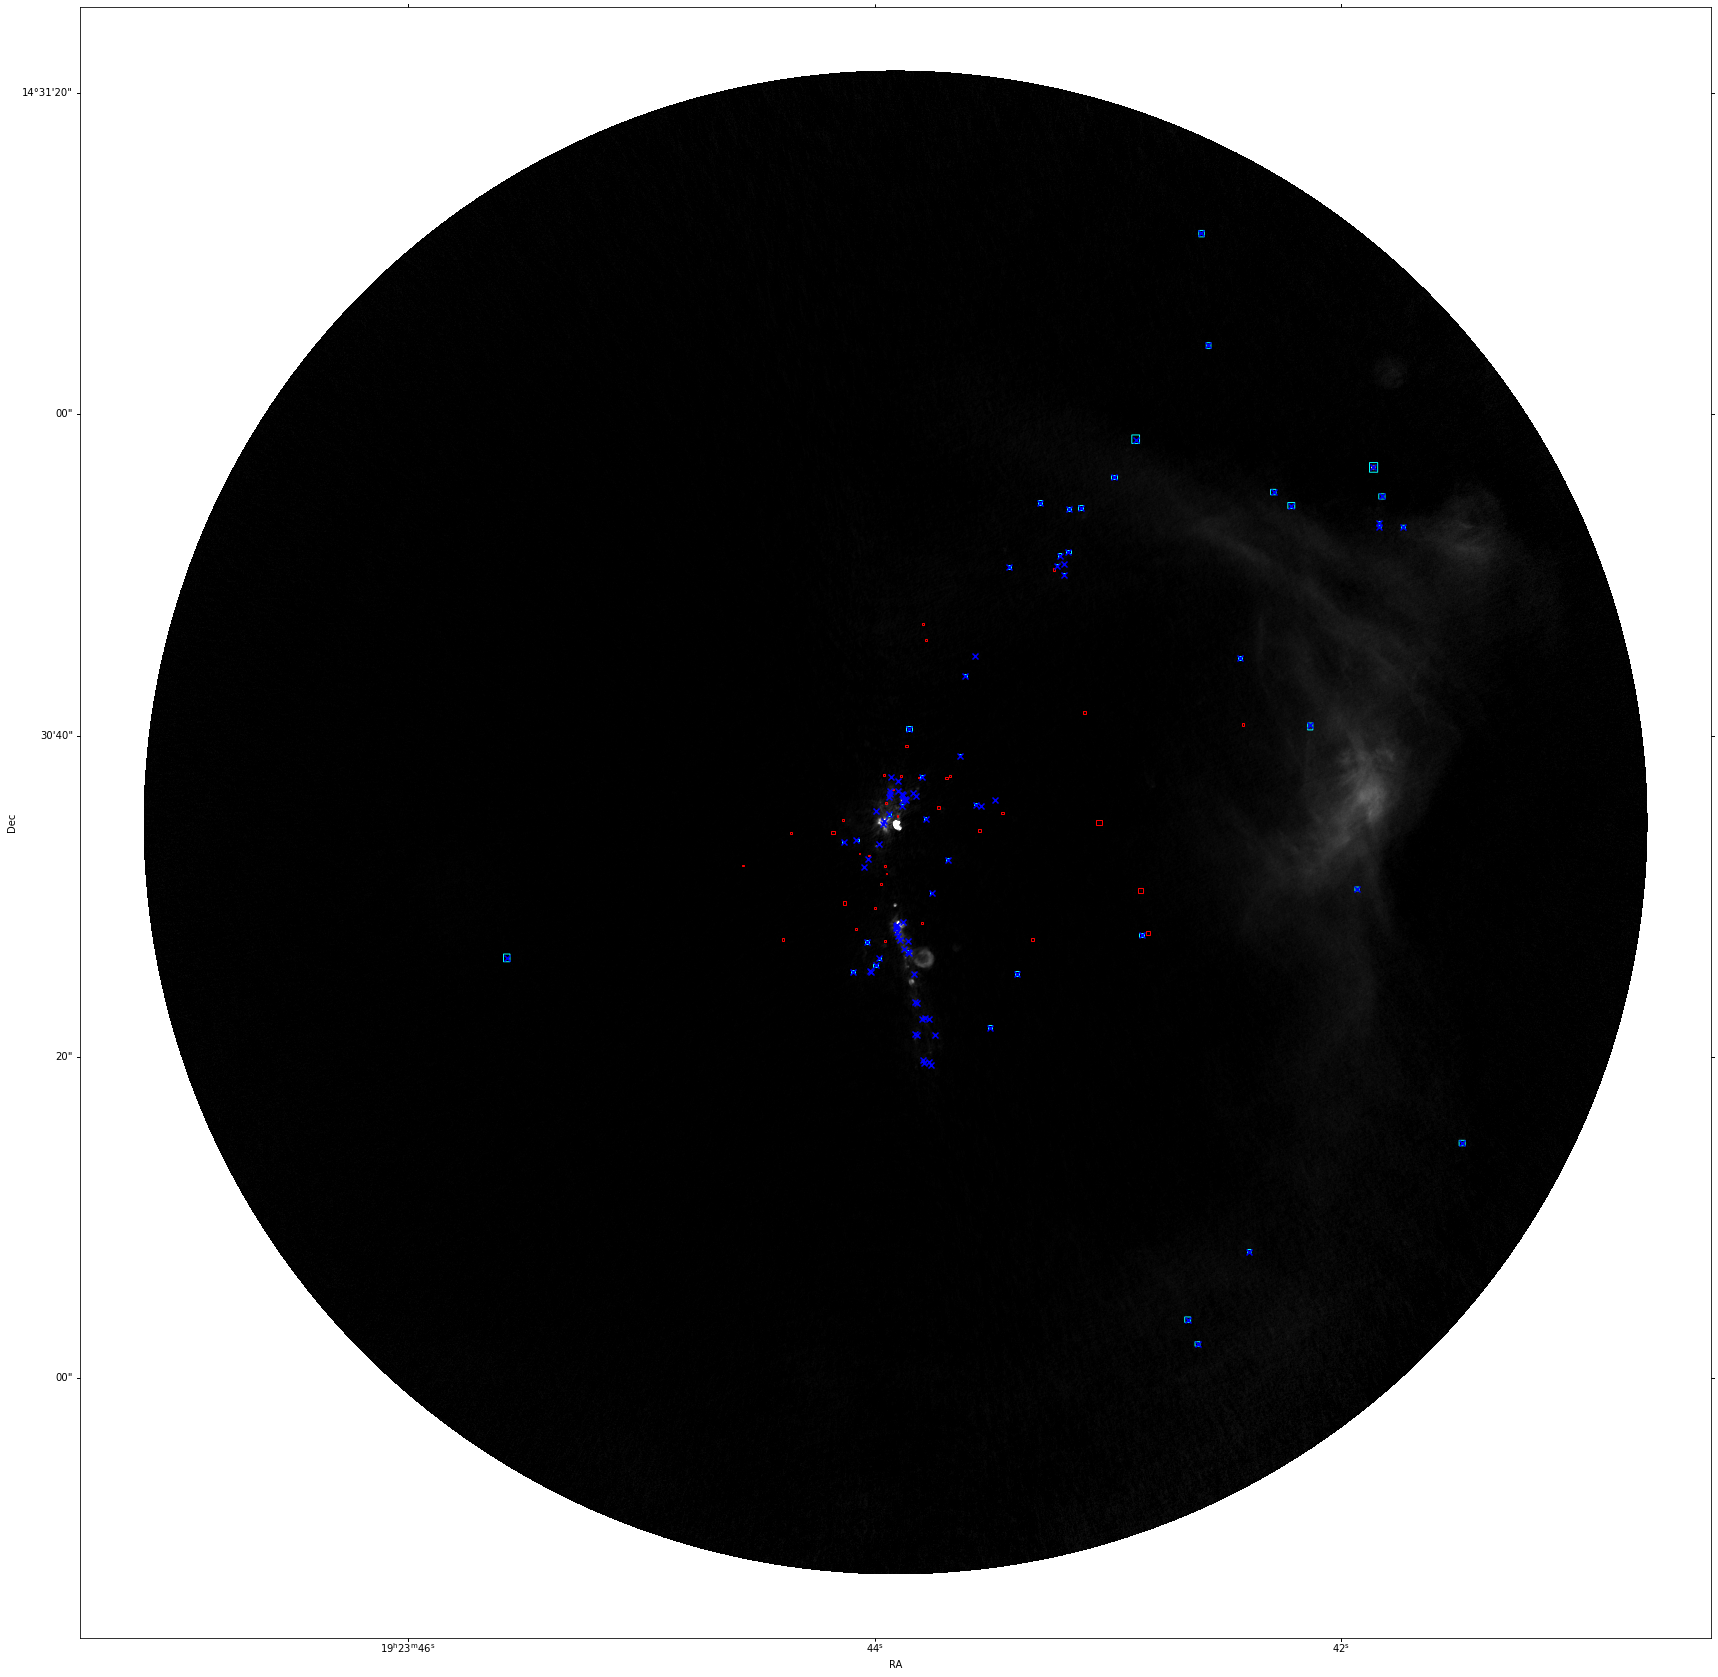

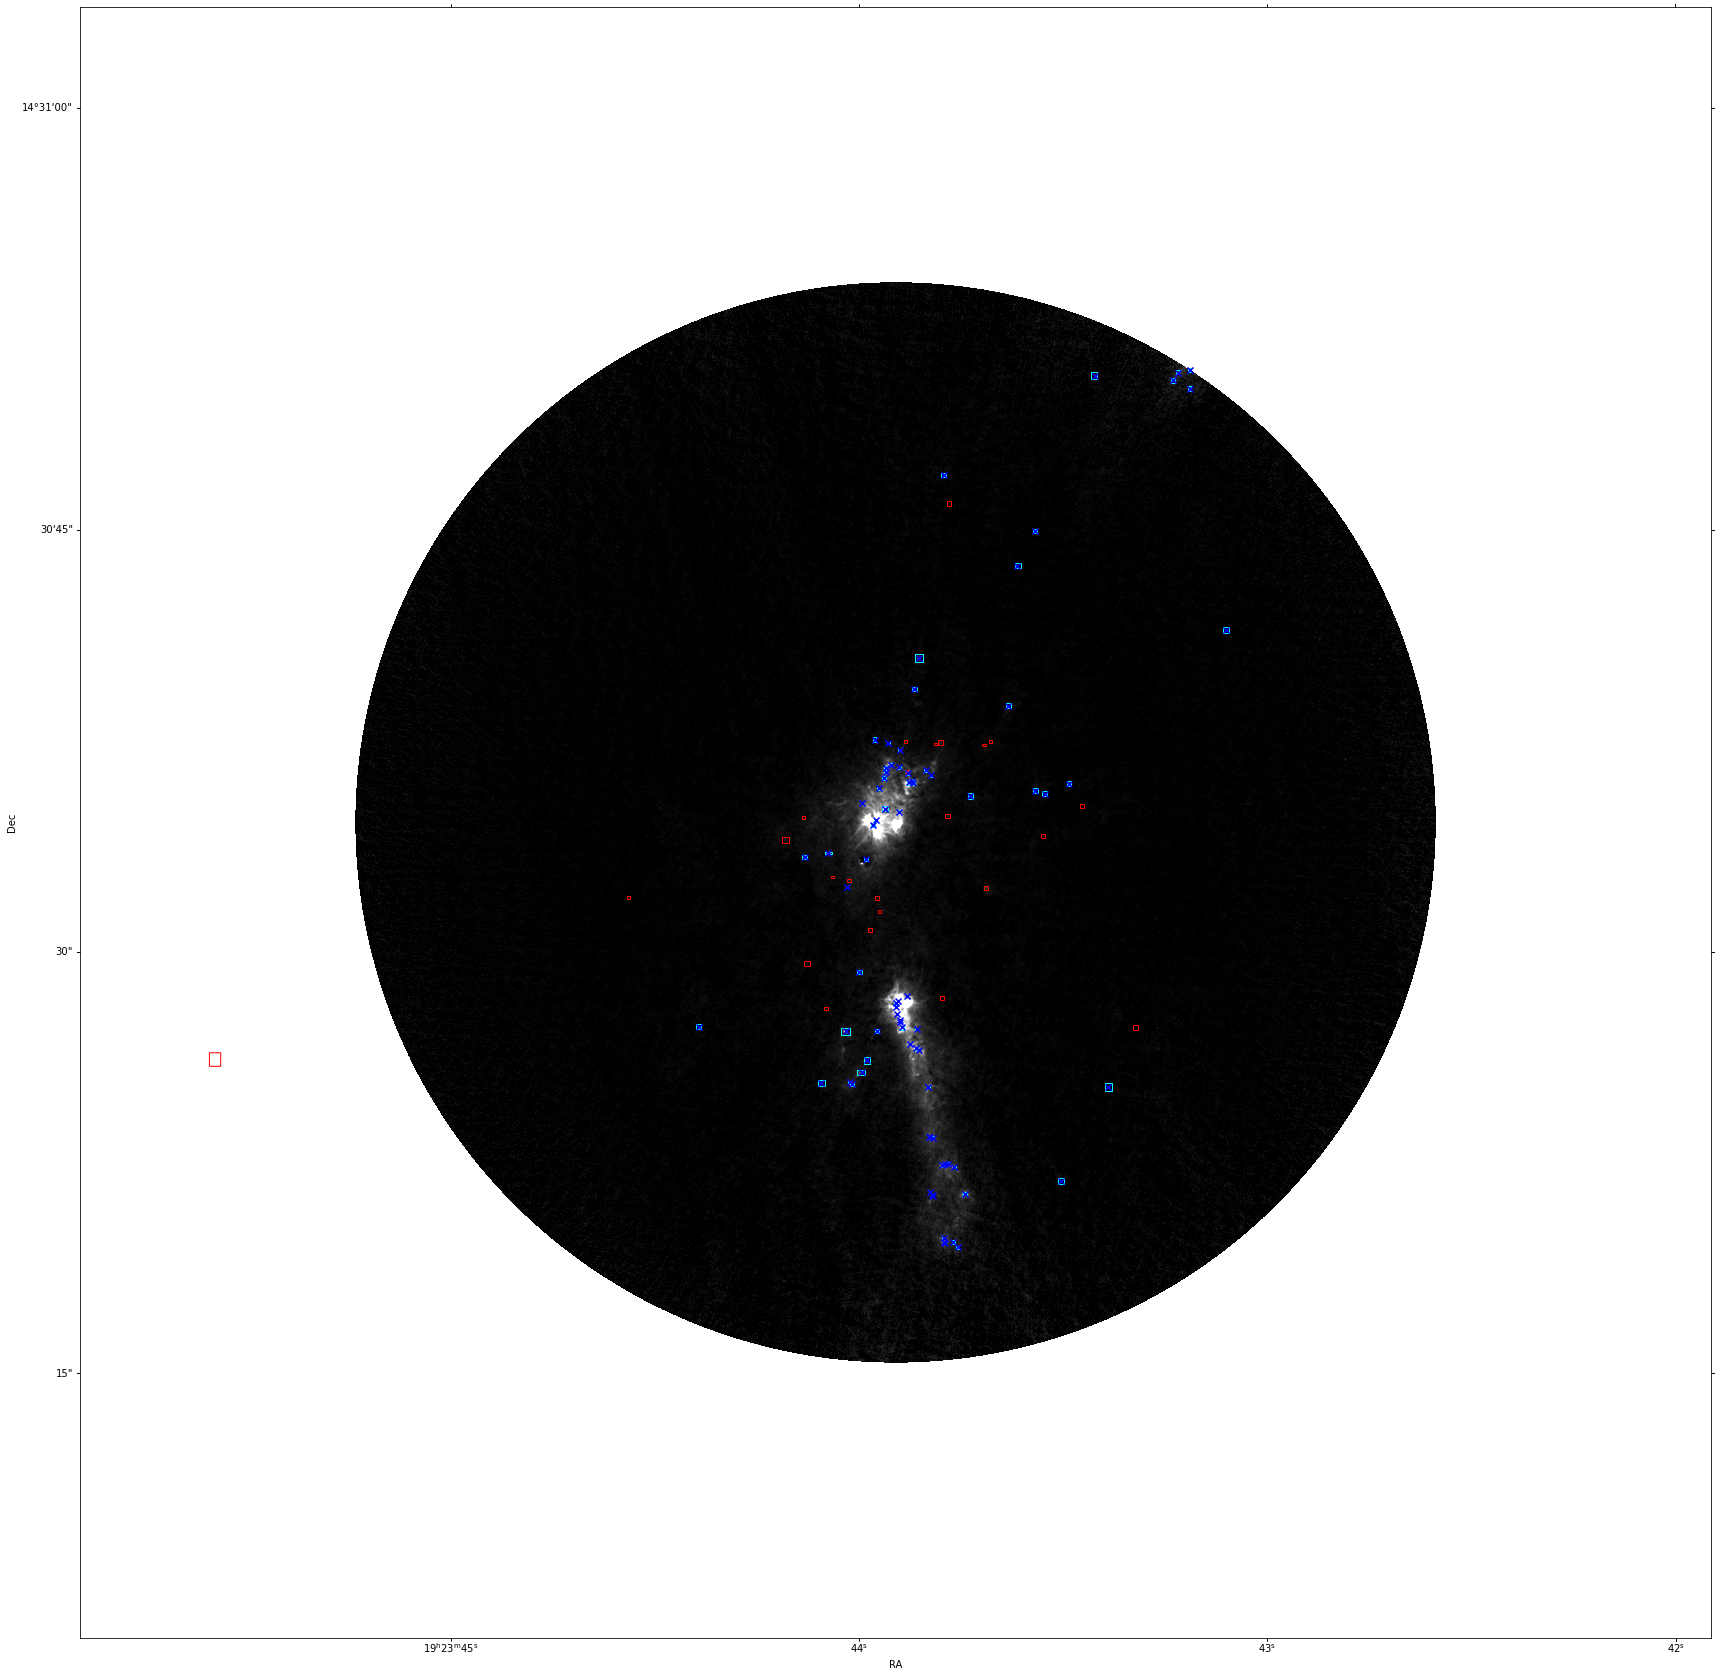

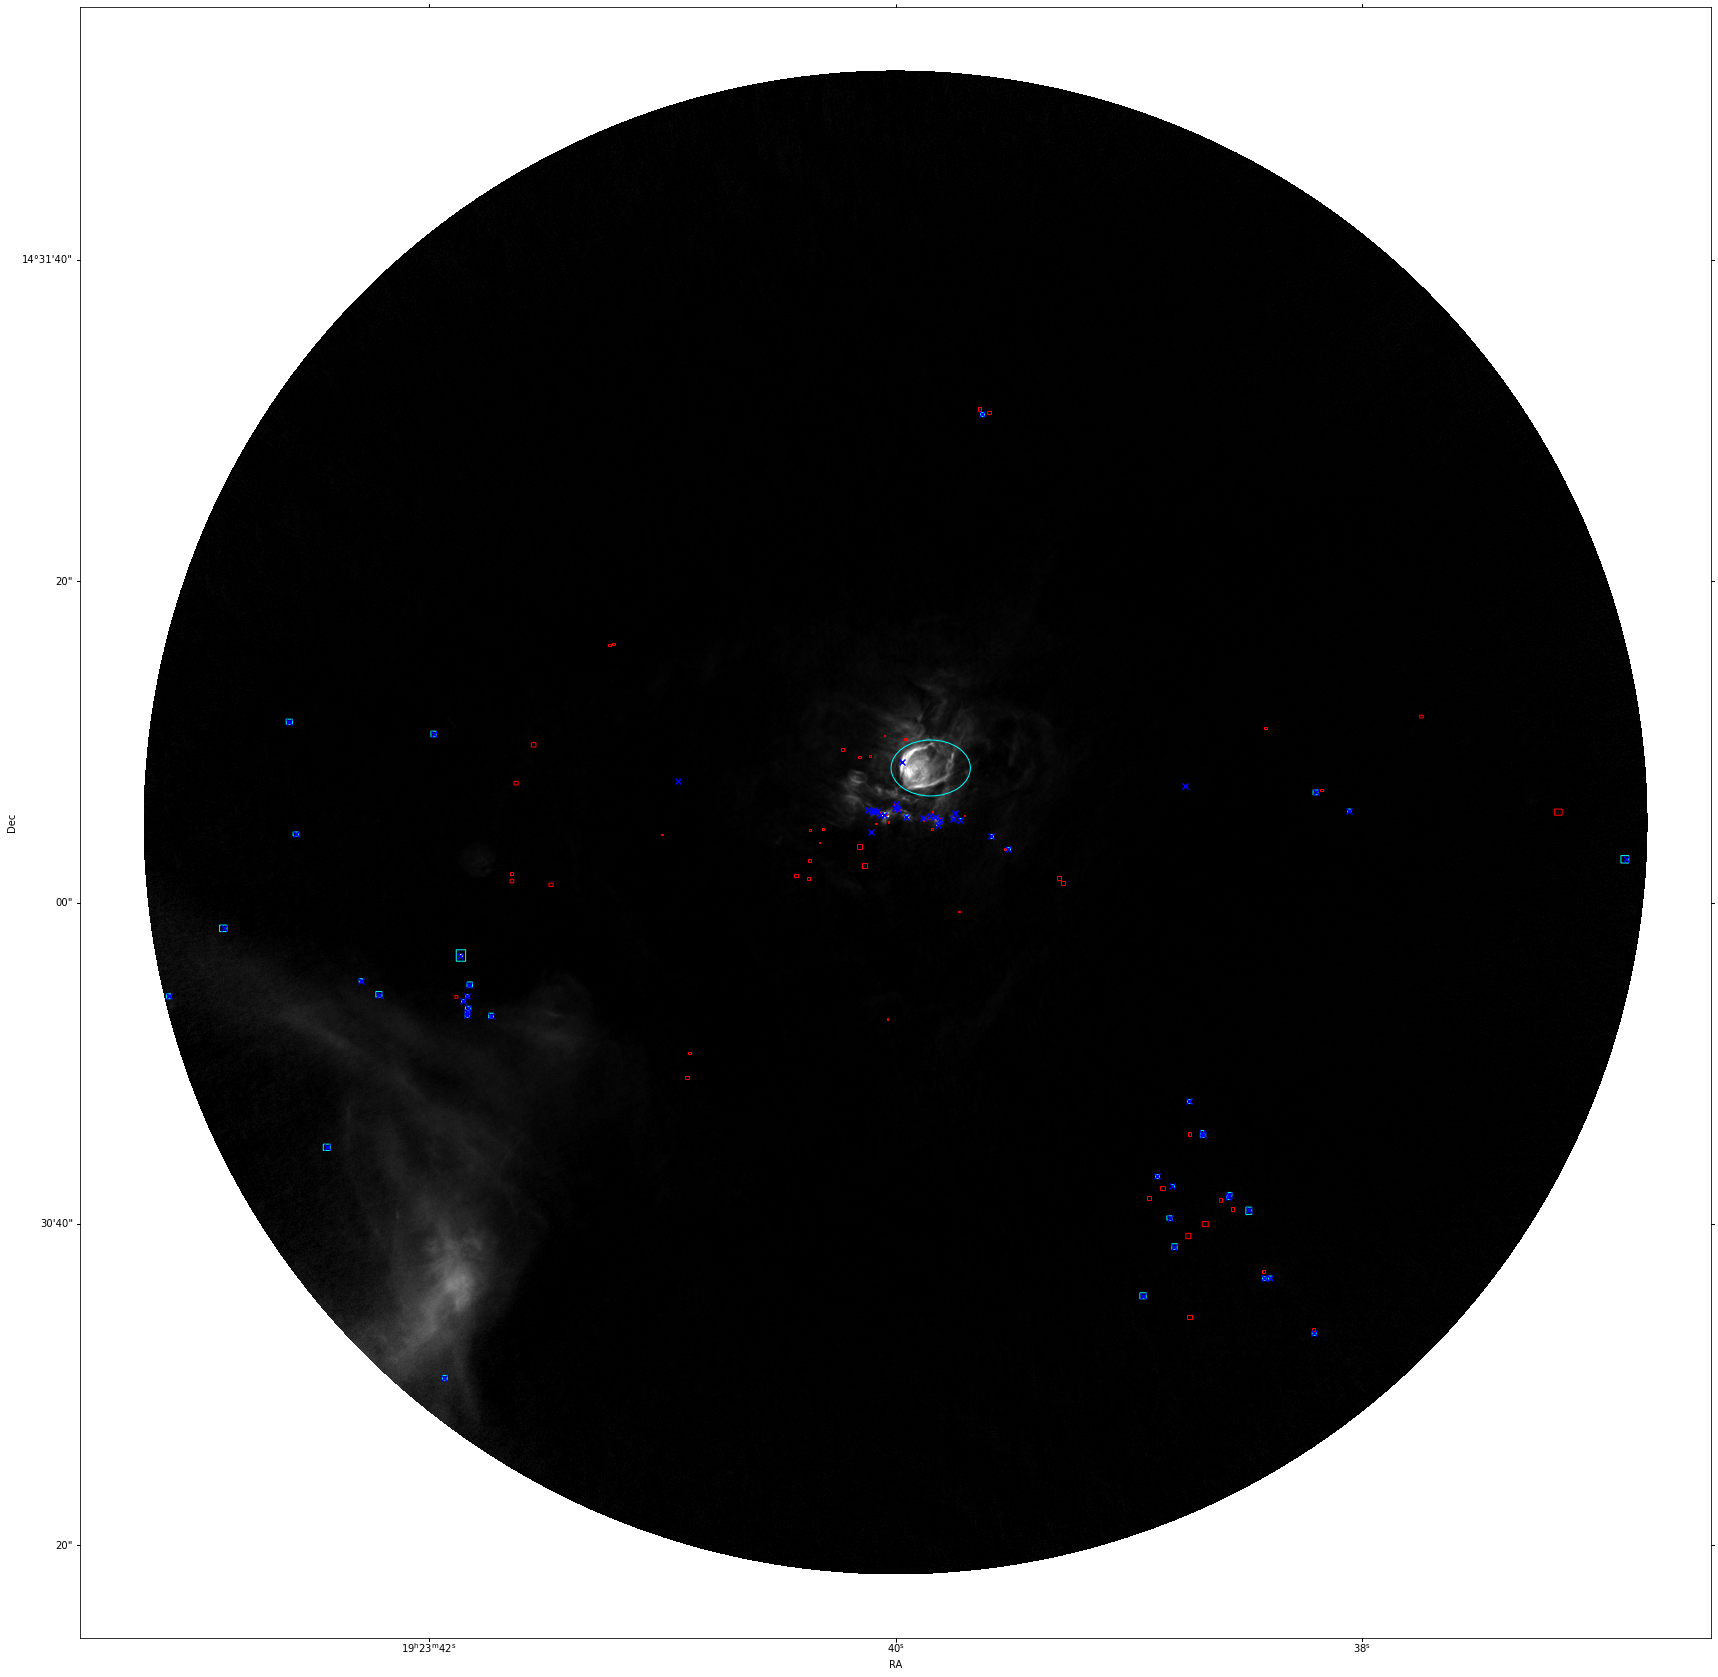

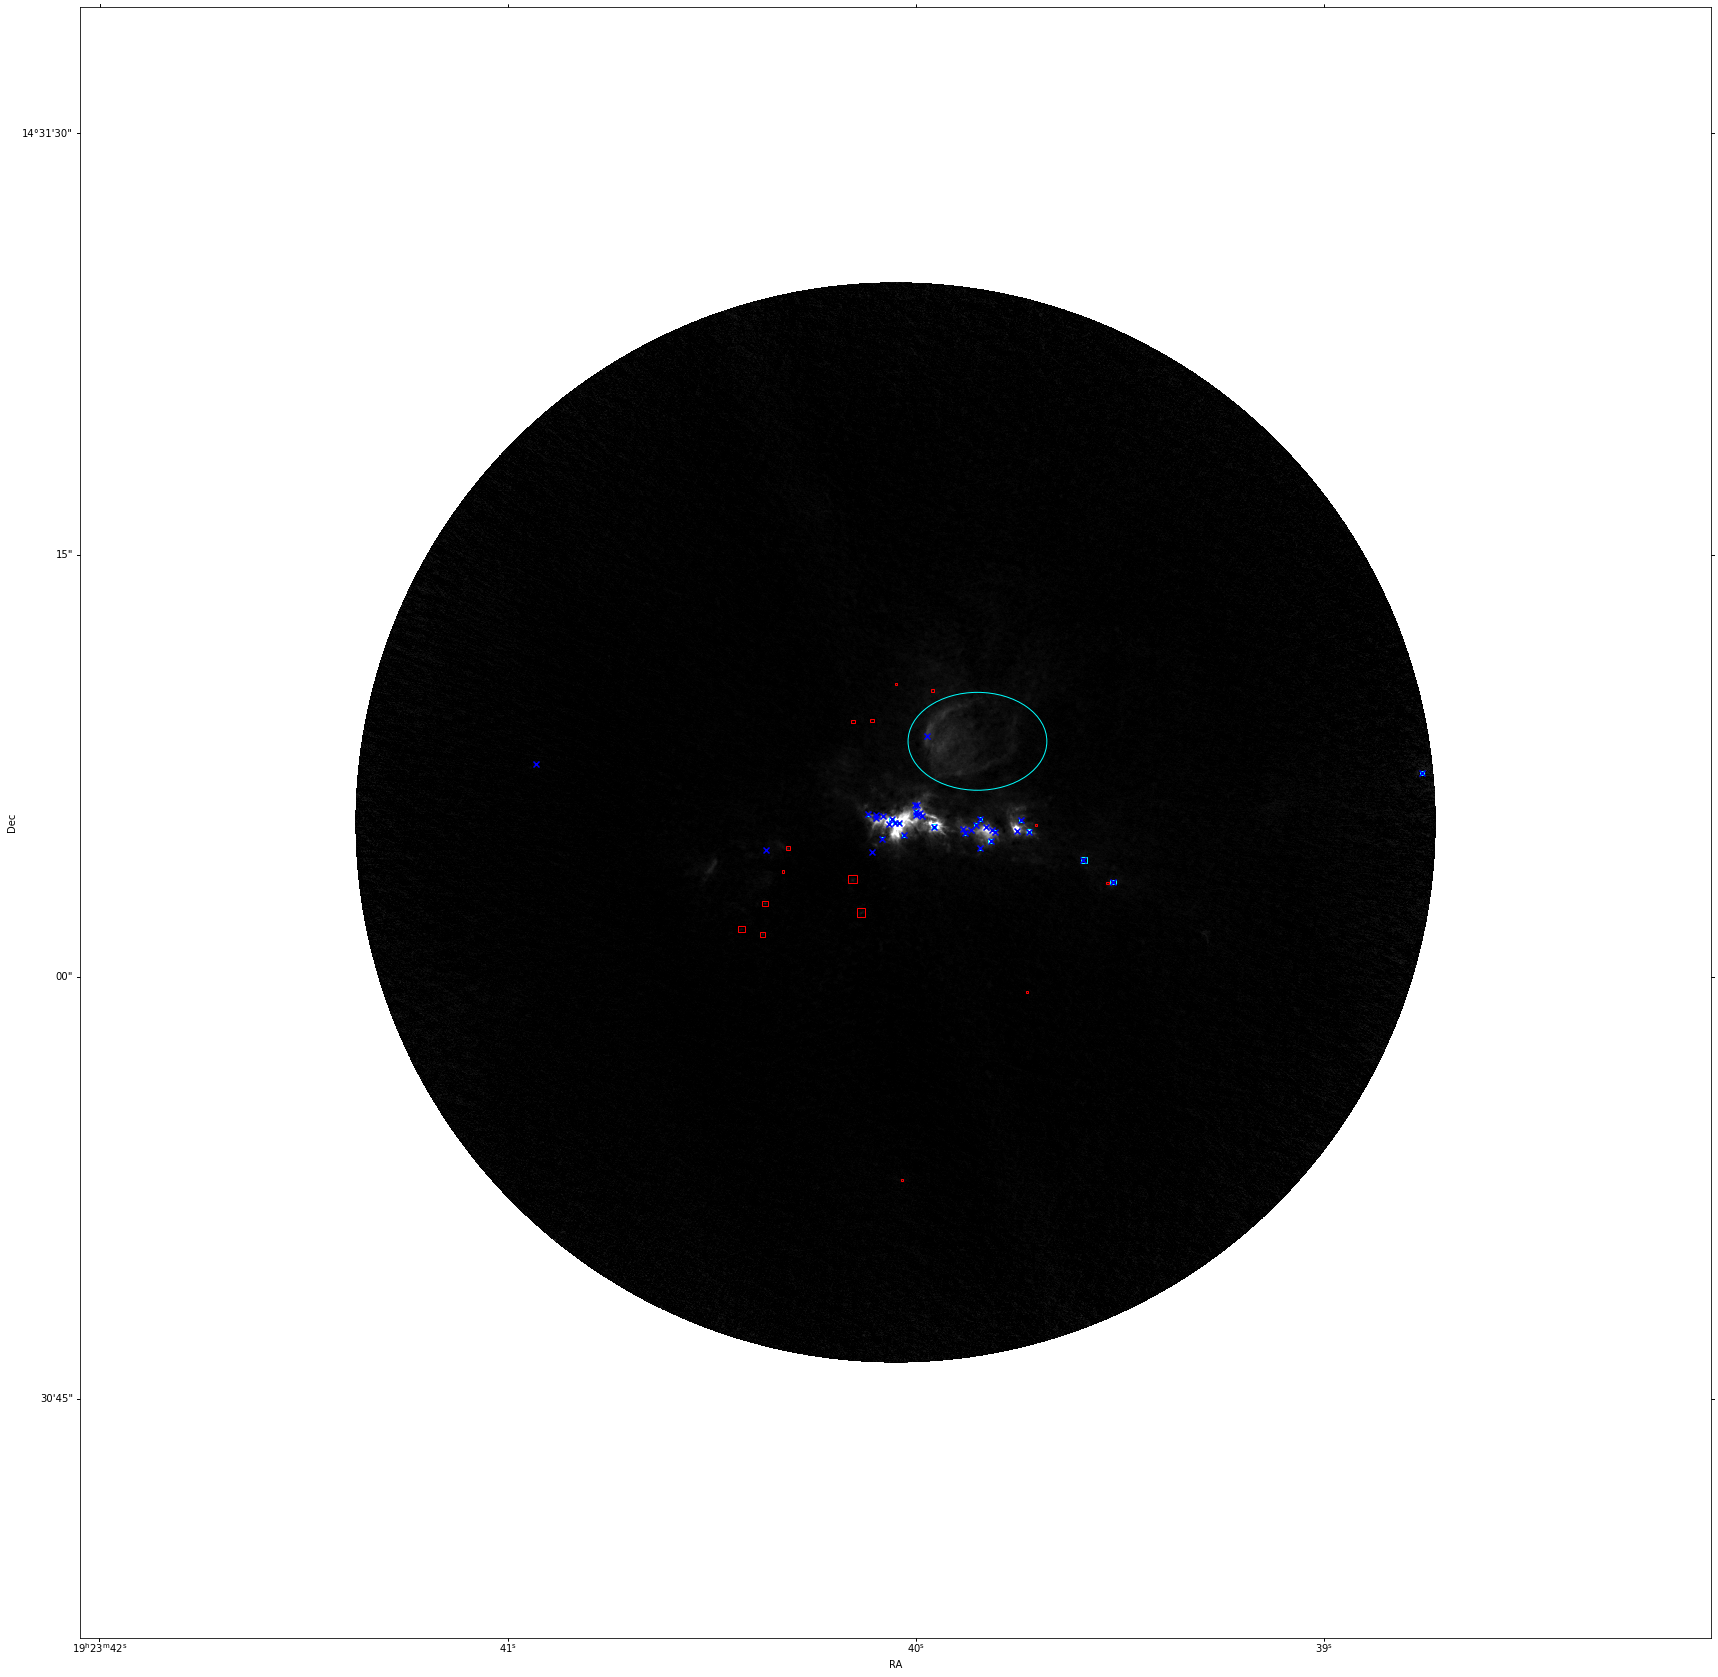

In [20]:
for region in ['W51-E', 'W51-IRS2']:
    for band in ['B3', 'B6']:
        plot_main(region, band)